In [138]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(ggrepel)
    library(dplyr)
    library(tidyr)
    library(RColorBrewer)
    library(readr) # for parse_number()
    library(clusterProfiler)
    library(patchwork)
    library(jsonlite)
    library(ggpp)
})

In [47]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}   

In [48]:
merged_res_df = read.csv('copulacci_with_other_results.csv')

In [49]:
mosta_df = merged_res_df %>%
    mutate(celltype_direction = interaction) %>%
    separate(interaction, into=c("source", "target"), sep = "=") 

In [59]:
lr_info_df = read.csv('Embryo_sdm_geneInter.csv')

In [50]:
mosta_df %>% pull(celltype_direction) %>% unique

[1] "Neural crest=Neural crest"   "AGM=Neural crest"           
 [3] "Neural crest=AGM"            "Sclerotome=Neural crest"    
 [5] "Neural crest=Sclerotome"     "Mesenchyme=Neural crest"    
 [7] "Neural crest=Mesenchyme"     "Branchial arch=Neural crest"
 [9] "Neural crest=Branchial arch" "Heart=Neural crest"         
[11] "Neural crest=Heart"          "Neural crest=Brain"         
[13] "Brain=Neural crest"          "Neural crest=Notochord"     
[15] "Notochord=Neural crest"

In [60]:
mosta_df = merge(
    mosta_df,
    lr_info_df %>% select(c(X, interaction_name_2)) ,
    by.x = "LR_index",
    by.y = "X"
)

In [51]:
consider = c(
    'Neural crest=Neural crest',
    'Notochord=Neural crest',
    'Sclerotome=Neural crest',
    'Neural crest=Sclerotome',
    'Neural crest=Notochord',
    'Neural crest=Brain',
    'Branchial arch=Neural crest',
    'Brain=Neural crest'
)

In [52]:
consider

[1] "Neural crest=Neural crest"   "Notochord=Neural crest"     
[3] "Sclerotome=Neural crest"     "Neural crest=Sclerotome"    
[5] "Neural crest=Notochord"      "Neural crest=Brain"         
[7] "Branchial arch=Neural crest" "Brain=Neural crest"

In [133]:
dotplot = function(
    brca_df, 
    celltype_name, 
    filter_pos=FALSE, 
    FDR_cutoff = 0.1,
    n_term = 5,
    put_arrow = FALSE,
    vertical = FALSE
){
    consider = c(
    'Neural crest=Neural crest',
    'Notochord=Neural crest',
    'Sclerotome=Neural crest',
    'Neural crest=Sclerotome',
    'Neural crest=Notochord',
    'Neural crest=Brain',
    'Branchial arch=Neural crest',
    'Brain=Neural crest'
    )
    # brca_df_filter = brca_df %>% filter((source == celltype_name) | 
    #                 (target == celltype_name))

    brca_df = brca_df %>% filter(celltype_direction %in% consider)
    dacr_tbl = brca_df %>% 
            mutate(Correlation = copula_coeff) %>%
            group_by(celltype_direction) %>%
            mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
            ungroup() %>%
            mutate(log10_p.adjust = -log10(qval)) %>%
            mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
            mutate(Cluster = celltype_direction) 
    
    if (put_arrow){
        dacr_tbl = dacr_tbl %>%
            mutate(Cluster = gsub("="," → ", celltype_direction)) 
    }

    if(filter_pos){
        dacr_tbl = dacr_tbl %>% mutate(Correlation = copula_coeff) %>% filter(qval < FDR_cutoff) %>%
                group_by(Cluster) %>% filter(Correlation > 0) %>% arrange(Correlation) %>% 
                slice_tail(n=n_term) %>% ungroup
    }

    # if (filter_pos){
    #     dacr_tbl = dacr_tbl %>% filter(copula_coeff > 0)
    # }
        
    # dacr_tbl = brca_df %>%
    #     mutate(Correlation = copula_coeff) %>%
    #     mutate(qval = p.adjust(pval, method = "BH")) %>%
    #     mutate(log10_p.adjust = -log10(qval)) %>%
    #     mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
    #     mutate(Cluster = celltype_direction) %>%
    #     #mutate(Cluster = enc2utf8(gsub("="," → ", celltype_direction))) %>%
    #     mutate(Correlation = copula_coeff) %>% 
    #     group_by(Cluster) %>% arrange(Correlation) %>% slice_tail(n=n_term) %>% ungroup
    mat <- dacr_tbl %>% 
      # select(Correlation, celltype_direction, LR_index) %>%  
      select(Correlation, celltype_direction, interaction_name_2) %>%  
      tidyr::pivot_wider(names_from = celltype_direction, values_from = Correlation) %>% 
      data.frame() # make df as tibbles -> matrix annoying
    
    df_toplot = dacr_tbl 
    # df_toplot$lig_rec = factor(df_toplot$LR_index, levels=mat$LR_index)
    df_toplot$lig_rec = factor(df_toplot$interaction_name_2, levels=mat$interaction_name_2)
    theme_cancer = theme_bw() + theme(
        legend.position = "bottom", 
        axis.text = element_text(color="black"), 
        axis.text.x = element_text(size=14, angle = 90, vjust = 0.5, hjust=1),
        plot.margin = margin(0,0,0,0,'pt')
    )

    if(vertical){
         p_dot = ggplot(df_toplot, 
                       aes_string(
                           x="lig_rec", y="Cluster", 
                           fill="log10_p.adjust_cap", size="Correlation")) +
          geom_point(shape=21, color="black") +
          paletteer::scale_fill_paletteer_c("grDevices::Heat", direction = -1, 
                                            limits = c(-log10(FDR_cutoff), 3.1), 
                                            breaks = -log10(c(FDR_cutoff, 0.1, 0.05, 0.01, 0.001)), 
                                            labels = c(FDR_cutoff, "0.1", "0.05", "0.01", "0.001")) +
          #scale_size(range=c(1,7)) +
          scale_size_continuous(range = c(4, 7)) +
          theme_cancer +
          theme(
              axis.text = element_text(color="black"),
              axis.text.x = element_text(size=17, angle = 90, vjust =0.5, hjust=1)
          ) + 
          labs(y="", x="",title="", size="Correlation", fill="FDR") +
          theme(axis.text.y = element_text(size=18),
                axis.text.x = element_text(size=18)) +
          guides(fill = guide_colourbar(barwidth = 18, barheight = 1.5)) +
          theme(legend.position="bottom", legend.box="vertical",legend.text = element_text(size=16),
               legend.title = element_text(size=16)) +
          ggtitle(celltype_name) +
          theme(plot.title = element_text(hjust = 0.5))
    }else{

        p_dot = ggplot(df_toplot, 
                       aes_string(
                           x="Cluster", y="lig_rec", 
                           fill="log10_p.adjust_cap", size="Correlation")) +
          geom_point(shape=21, color="black") +
          paletteer::scale_fill_paletteer_c("grDevices::Heat", direction = -1, 
                                            limits = c(-log10(FDR_cutoff), 3.1), 
                                            breaks = -log10(c(FDR_cutoff, 0.1, 0.05, 0.01, 0.001)), 
                                            labels = c(FDR_cutoff, "0.1", "0.05", "0.01", "0.001")) +
          scale_size(range=c(1,7)) +
          theme_cancer +
          theme(
              axis.text = element_text(color="black"),
              axis.text.x = element_text(size=17, angle = 90, vjust = 0.5, hjust=1)
          ) + 
          labs(y="", x="",title="", size="Correlation", fill="FDR") +
          theme(axis.text.y = element_text(size=15)) +
          theme(legend.position="right", legend.box="vertical",legend.text = element_text(size=15),
               legend.title = element_text(size=15)) +
          ggtitle(celltype_name) +
          theme(plot.title = element_text(hjust = 0.5))
    }

    return(p_dot)

    # if (vertical){
    #     p_dot = ggplot(df_toplot, 
    #            aes_string(
    #                x="lig_rec", y="Cluster", 
    #                fill="log10_p.adjust_cap", size="Correlation")) +
    #       geom_point(shape=21, color="black") +
    #       paletteer::scale_fill_paletteer_c("grDevices::Heat", direction = -1, 
    #                                         limits = c(-log10(0.2), 3.1), 
    #                                         breaks = -log10(c(FDR_cutoff, 0.1, 0.05, 0.01, 0.001)), 
    #                                         labels = c(FDR_cutoff, "0.1", "0.05", "0.01", "0.001")) +
    #       #scale_size(range=c(1,7)) +
    #       theme_cancer +
    #       theme(axis.text = element_text(size=12, color="black")) + 
    #       labs(y="", x="",title="", size="Correlation", fill="FDR") +
    #       theme(axis.text.y = element_text(size=14)) +
    #       theme(legend.position="bottom", legend.box="vertical")
    # }else{
    #     p_dot = ggplot(df_toplot, 
    #                aes_string(
    #                    x="Cluster", y="lig_rec", 
    #                    fill="log10_p.adjust_cap", size="Correlation")) +
    #   geom_point(shape=21, color="black") +
    #   paletteer::scale_fill_paletteer_c("grDevices::Heat", direction = -1, 
    #                                     limits = c(-log10(0.2), 3.1), 
    #                                     breaks = -log10(c(FDR_cutoff, 0.1, 0.05, 0.01, 0.001)), 
    #                                     labels = c(FDR_cutoff, "0.1", "0.05", "0.01", "0.001")) +
    #   scale_size(range=c(1,7)) +
    #   theme_cancer +
    #   theme(axis.text = element_text(size=12, color="black")) + 
    #   labs(y="", x="",title="", size="Correlation", fill="FDR") +
    #   theme(axis.text.y = element_text(size=14)) +
    #   theme(legend.position="right", legend.box="vertical") +
    #   ggtitle(celltype_name) +
    #   theme(plot.title = element_text(hjust = 0.5))
    # }

    return(p_dot)
}

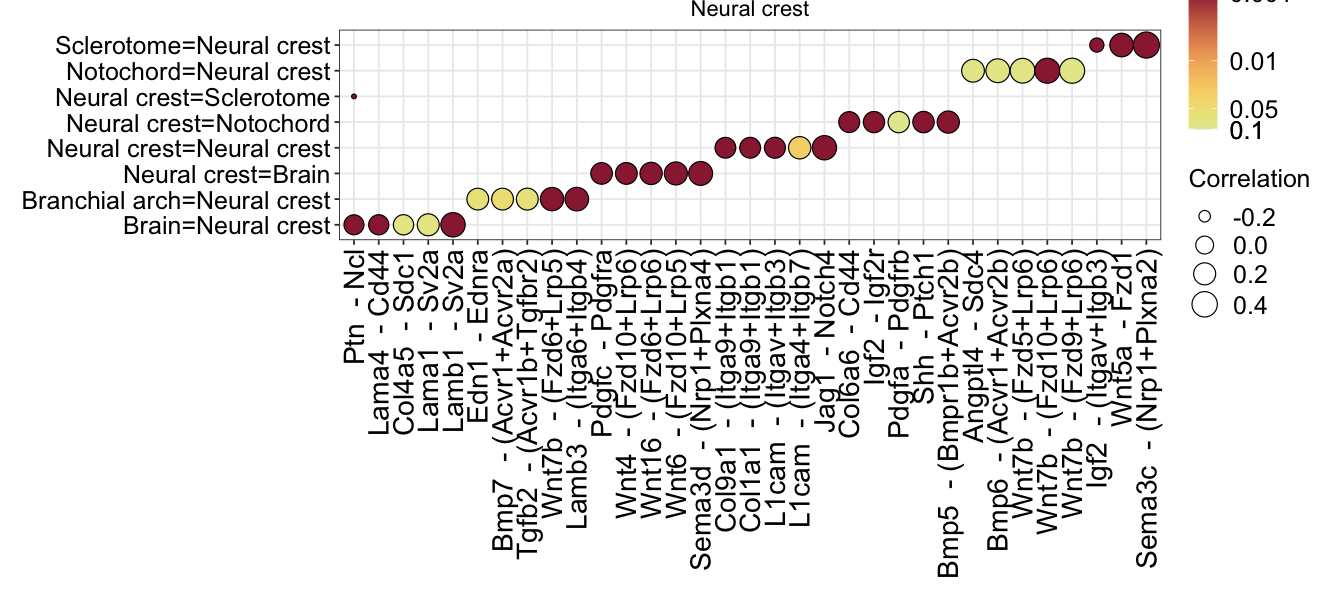

In [97]:
fig.size(5,11)
dotplot(mosta_df, 
        'Neural crest',filter_pos=TRUE, FDR_cutoff=0.1, n_term=5, vertical = TRUE)

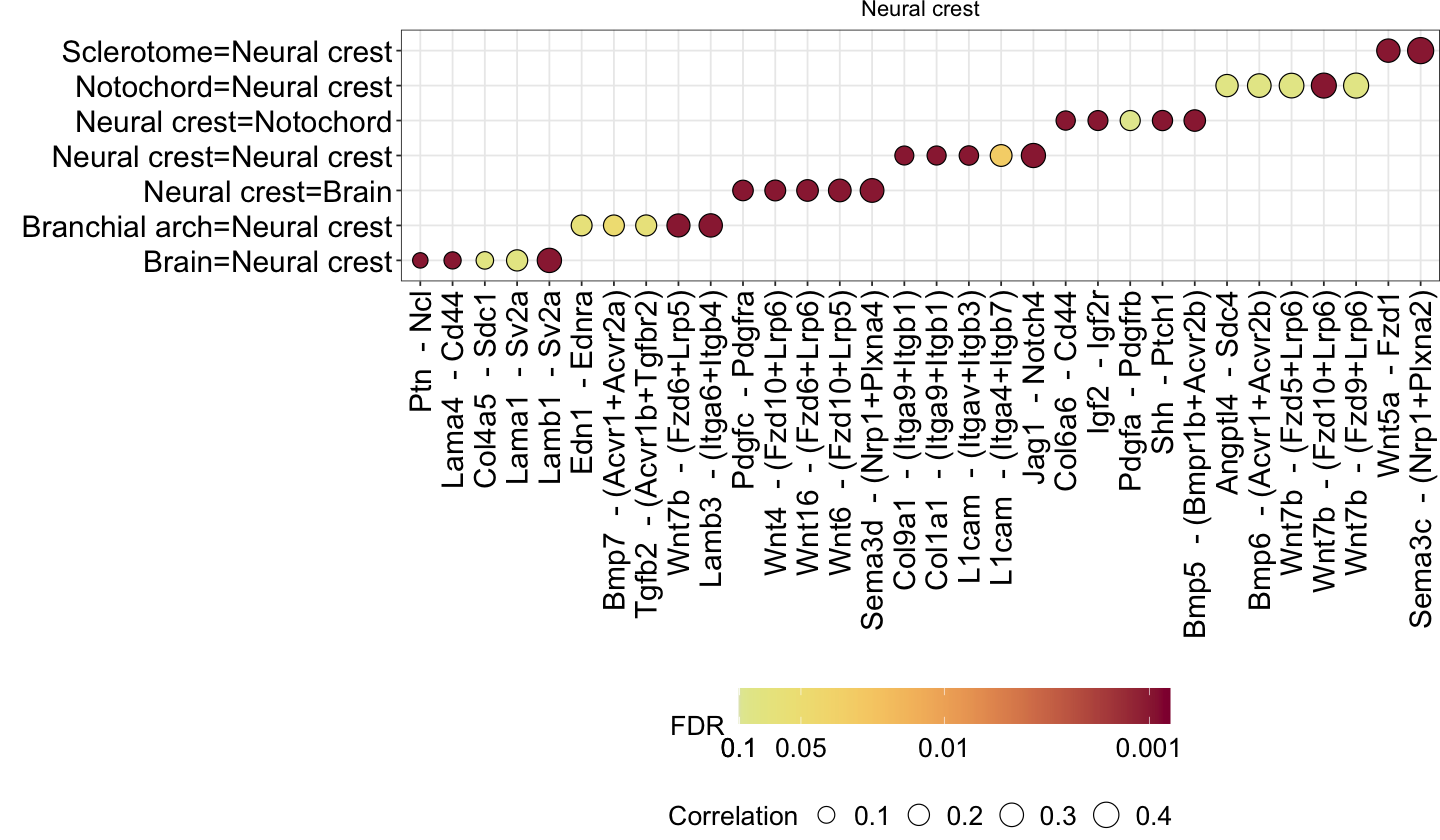

In [134]:
fig.size(7,12)
dotplot(mosta_df, 
        'Neural crest',filter_pos=TRUE, FDR_cutoff=0.1, n_term=5, vertical = TRUE)

In [135]:
fig.size(8.5,5)
parent.dir = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures_version_2/'
file_name = "MOSTA_neural_crest_dotplot_3_12.png"
file_path <- file.path(parent.dir , file_name)
p1 = dotplot(mosta_df, 
        'Neural crest',filter_pos=TRUE, FDR_cutoff=0.1, n_term=5, vertical = TRUE,put_arrow = TRUE)
ggsave(file_path, p1, height=7, width=12, dpi = 500)

In [158]:
de_like_plot = function(brca_df, gpair, FDR_cutoff = 0.2, 
                        corr_cutoff = 0.3, ntop = 5){

    decci = brca_df %>% filter(celltype_direction == gpair)
    decci = decci %>%
    mutate(
        copula_pval = if_else( copula_pval == 0.0, 1/500, copula_pval)
    ) %>%
    mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
    mutate(log10_p.adjust = -log10(qval)) %>%
            mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
    mutate(
        correlated = case_when(
            (copula_coeff > corr_cutoff) & (qval < FDR_cutoff) ~ 'Pos',
            (copula_coeff < -corr_cutoff) & (qval < FDR_cutoff) ~ 'Neg',
            TRUE ~ 'No'
        )
    )
    p = ggplot(data=decci, 
       aes(x=copula_coeff, 
           y=log10_p.adjust, 
           col=correlated)) +
        geom_point() + 
        geom_label_repel(
            data = decci %>% filter(correlated != 'No') %>%
                arrange(abs(copula_coeff)) %>% slice_tail(n=5),
            aes(x =copula_coeff, 
                y=log10_p.adjust,label=interaction_name_2),
            box.padding = 0.1,
            max.overlaps = Inf,
            size = 5,
            min.segment.length = 0,
            xlim = c(NA, NA),
            ylim = c(NA, NA)
        ) +
        theme_bw() +
        scale_color_manual(values=c("blue", "black", "red")) +
        geom_vline(xintercept=c(-0.2, 0.2), col="red") +
        geom_hline(yintercept=-log10(0.2), col="red") +
         theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            axis.line = element_line(colour = "black"),
            # axis.title.x = element_blank(),
            # axis.title.y = element_blank(),
            axis.text.x = element_text(family = "Helvetica", size = 18, color = "black"),
            axis.text.y = element_text(family = "Helvetica", size = 18, color = "black"),
            legend.text = element_text(size=16),
            legend.title = element_text(size=16)
          )
     return(p)   
}

In [154]:
plot_scatter = function(
    brca_df,
    xcol = "copula_coeff",
    ycol = "scc",
    gpair = 'Tumor=Surrounding tumor',
    use_cutoff=TRUE,
    use_diff=TRUE,
    FDR_cutoff=0.1,
    ntop=5,
    p_value="qval",
    x_shift=0.2,
    y_shift=0.2,
    pad = 0.1
){

    df_ct = brca_df %>% 
        mutate(Correlation = copula_coeff) %>%
        group_by(celltype_direction) %>%
        mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
        ungroup() %>%
        mutate(log10_p.adjust = -log10(qval)) %>%
        mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
        mutate(Cluster = celltype_direction) %>%
        filter(celltype_direction == gpair)
    
    df_ct = df_ct %>% 
        select(c(LR_index, copula_coeff, log10_p.adjust_cap, scc, 
                 global_I, qval, interaction_name_2))
    
    xmax = max(df_ct[[xcol]]) 
    xmin = min(df_ct[[xcol]])
    ymax = max(df_ct[[ycol]]) 
    ymin = min(df_ct[[ycol]])
    gmin = min(xmin, ymin)
    gmax = max(xmax, ymax)
    gmax = gmax + pad
    
    df_ct$method_diff = abs(df_ct[[xcol]] - df_ct[[ycol]])
    if(use_cutoff){
            if (use_diff){
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(method_diff) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)
            }else{
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(abs(copula_coeff)) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)    
            }
            
        }else{
            if (use_diff){
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(method_diff) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)
            }else{
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(abs(copula_coeff)) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)    
            }
        }
    
    
    
    p = ggplot(df_ct, aes_string(x = xcol, y = ycol, color = p_value)) +
          scale_color_gradient(
            # limits = c(-log10(max(df_ct$qval)), 3.1), 
            # breaks = -log10(c(0.9, 0.1, 0.05, 0.01, 0.001)), 
            # labels = c("0.9", "0.1", "0.05", "0.01", "0.001"),
            low = "blue", high = "grey") +
          geom_point(alpha = 0.6, size=3) + 
          geom_point(data = df_ct %>% filter(LR_index %in% top_candidates), 
                     color = "red", size = 3.5, stroke=1.3, shape = 1) +
        xlim(-gmax,gmax) +
        ylim(-gmax,gmax) +
        labs(color ='FDR') +
        geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal dashed line
          geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical dashed line
        geom_label_repel(
            data = df_ct %>% filter(LR_index %in% top_candidates),
            aes_string(x = xcol, y= ycol, label = "interaction_name_2"),
            position=position_nudge_center(x = x_shift,y= y_shift ,
                                           center_x = 0.0
                                           # center_y = 0.0
                                          ),
            #family = "Poppins",
            size = 5,
            min.segment.length = 0, 
            seed = 42, 
            box.padding = 0.1,
            max.overlaps = Inf,
            xlim = c(NA, NA),
            ylim = c(NA, NA),
            arrow = arrow(length = unit(0.01, "npc")),
            # nudge_x = .1,
            # #nudge_y = -.1,
            #fill="white",
            color = "red"
          ) +
          theme_bw() +
          theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            axis.line = element_line(colour = "black"),
            # axis.title.x = element_blank(),
            # axis.title.y = element_blank(),
            axis.text.x = element_text(family = "Helvetica", size = 18, color = "black"),
            axis.text.y = element_text(family = "Helvetica", size = 18, color = "black"),
            legend.text = element_text(size=16),
            legend.title = element_text(size=16)
          )
    return(p)
}

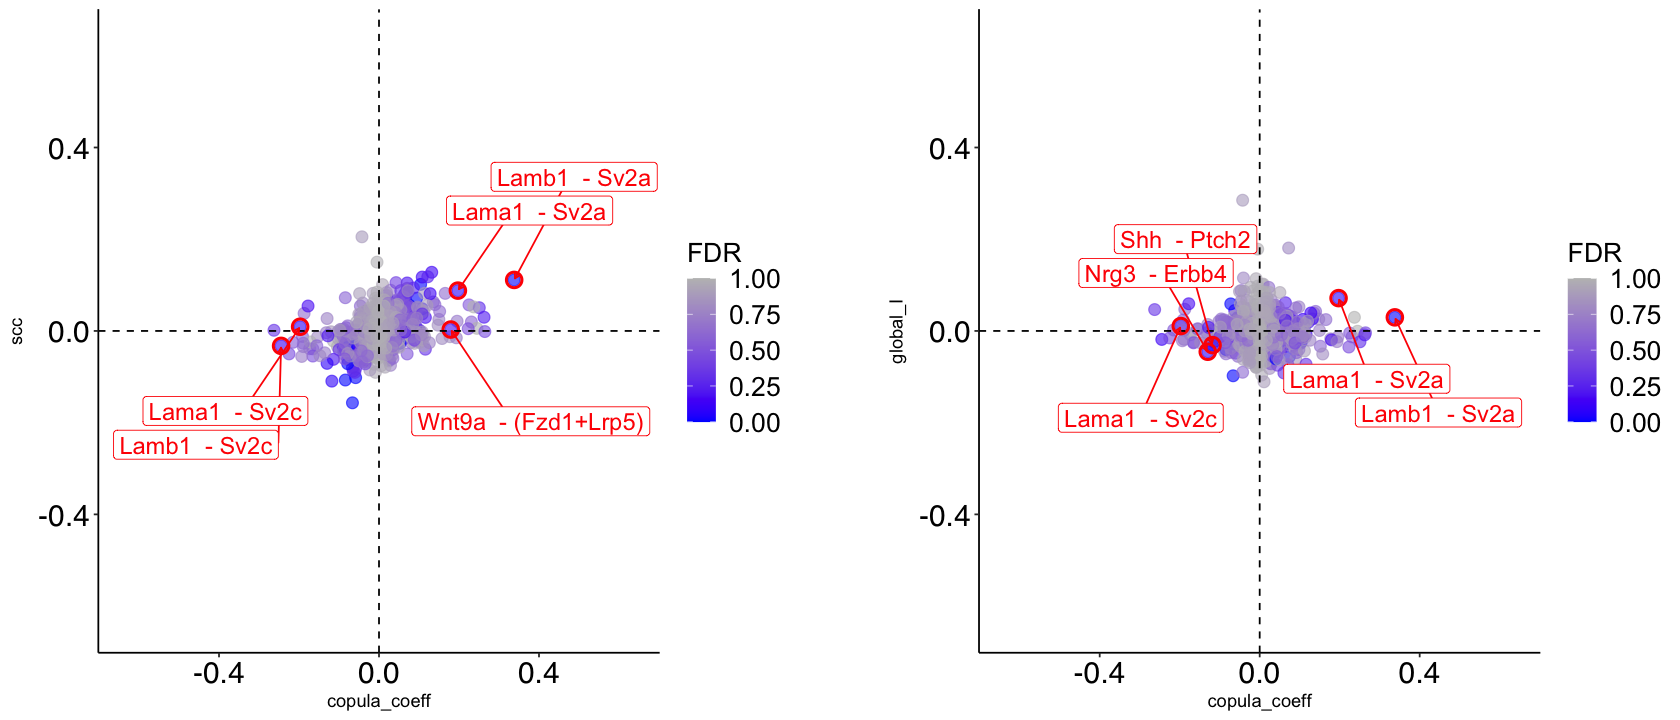

In [156]:
fig.size(6, 14)
gpair = 'Brain=Neural crest'
p1 = plot_scatter(mosta_df, "copula_coeff", "scc", gpair,ntop=5,FDR_cutoff=0.2, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3)
p2 = plot_scatter(mosta_df, "copula_coeff", "global_I", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3,x_shift=0.1, y_shift=-0.2)
p3 = (p1 + theme(plot.margin = unit(c(0,30,0,0), "pt"))) +
(p2 + theme(plot.margin = unit(c(0,0,0,30), "pt")))
p3

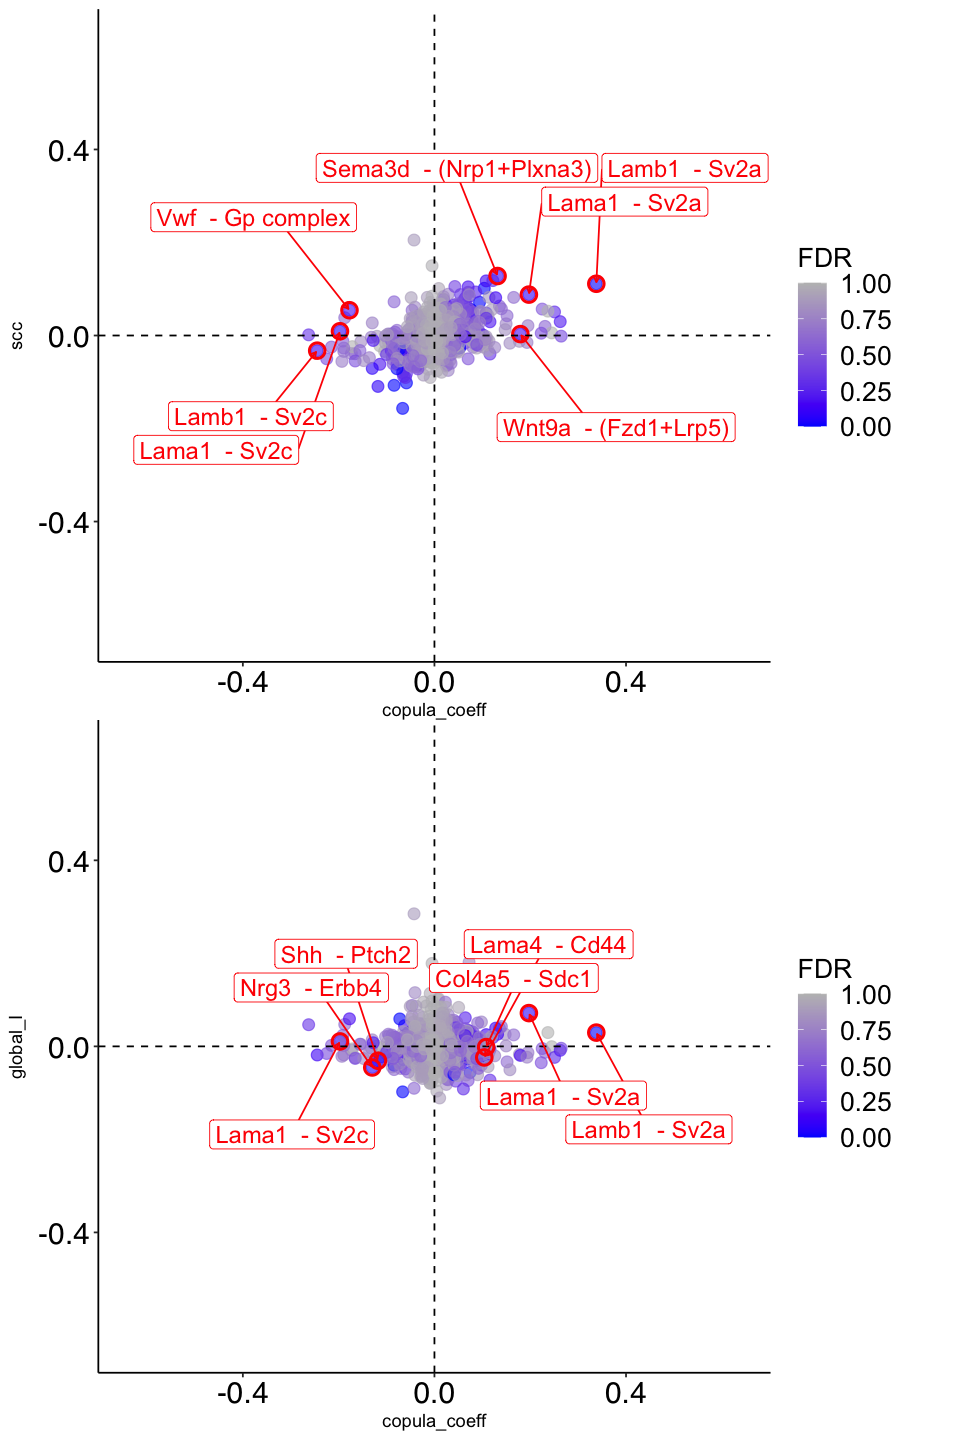

In [165]:
fig.size(12, 8)
gpair = 'Brain=Neural crest'
p1 = plot_scatter(mosta_df, "copula_coeff", "scc", gpair,ntop=7,FDR_cutoff=0.2, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3)
p2 = plot_scatter(mosta_df, "copula_coeff", "global_I", gpair,ntop=7,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3,x_shift=0.1, y_shift=-0.2)

p3 = p1 / p2
p3

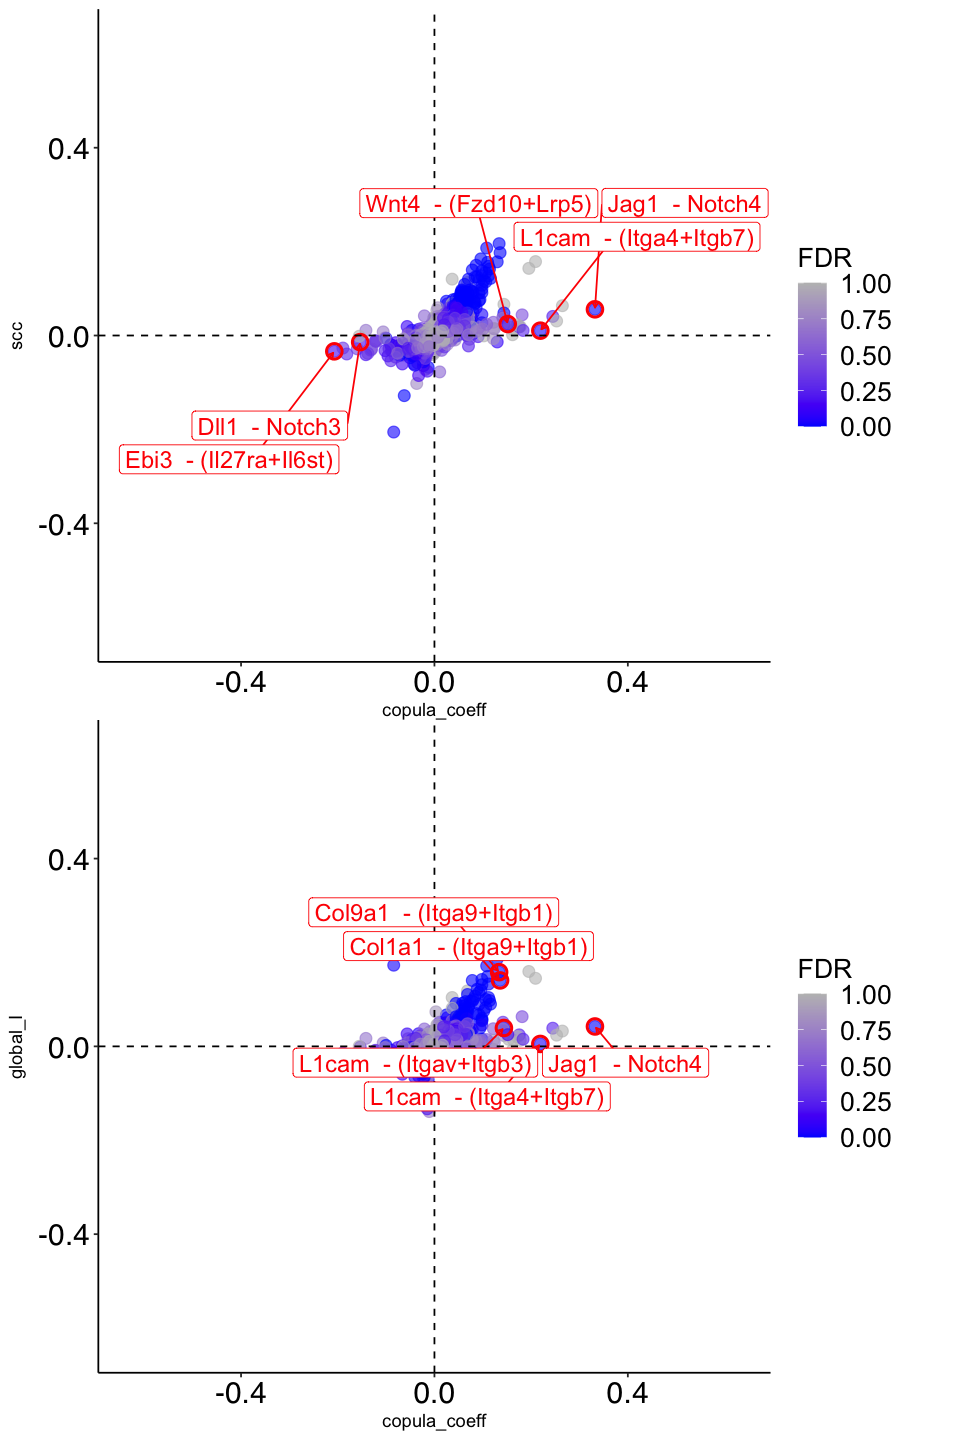

In [175]:
fig.size(12, 8)
gpair = 'Neural crest=Neural crest'
p1 = plot_scatter(mosta_df, "copula_coeff", "scc", gpair,ntop=5,FDR_cutoff=0.2, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3)
p2 = plot_scatter(mosta_df, "copula_coeff", "global_I", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3,x_shift=-0.1, y_shift=0.1)

p3 = p1 / p2
p3

In [164]:
file_name = "MOSTA_neural_crest_scatter_3_15.png"
file_path <- file.path(parent.dir , file_name)
ggsave(file_path, p3, width=7.5, height=12,dpi = 500)

In [157]:
fig.size(6,14)
parent.dir = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures_version_2/'
file_name = "MOSTA_neural_crest_scatter_3_12.png"
file_path <- file.path(parent.dir , file_name)
ggsave(file_path, p3, height=6, width=14, dpi = 500)

In [147]:
lr_info_df %>% filter(X == 'LAMB2_SV2A')

X,interaction_name,pathway_name,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
LAMB2_SV2A,LAMB2_SV2A,LAMININ,,,,,KEGG: mmu04512,ECM-Receptor,Lamb2 - Sv2a


In [160]:
lr_info_df %>% filter(X == 'LAMA4_CD44')

X,interaction_name,pathway_name,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
LAMA4_CD44,LAMA4_CD44,LAMININ,,,,,KEGG: mmu04512,ECM-Receptor,Lama4 - Cd44


In [145]:
mosta_df %>% 
    mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
    filter(celltype_direction == 'Brain=Neural crest') %>% filter(qval < 0.1) %>% arrange(desc(copula_coeff))

LR_index,copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval,source,target,celltype_direction,interaction_name_2,qval
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
LAMB1_SV2A,0.33792793,-10.365903,-12.551818,copula,0.000000000,0.0000000,0.111237710,0.001996008,0.029621087,2.883447e-150,Brain,Neural crest,Brain=Neural crest,Lamb1 - Sv2a,0.00000000
LAMA1_SV2A,0.19720721,-10.204697,-12.551818,copula,0.001996008,0.1114913,0.087931092,0.001996008,0.071568267,0.000000e+00,Brain,Neural crest,Brain=Neural crest,Lama1 - Sv2a,0.05841807
SEMA3D_NRP1_PLXNA3,0.13180180,-10.814561,-10.060521,copula,0.003992016,0.1737778,0.127909172,0.001996008,0.026186590,8.135477e-118,Brain,Neural crest,Brain=Neural crest,Sema3d - (Nrp1+Plxna3),0.09582473
WNT5A_FZD6,0.12783784,-10.204697,-10.647035,copula,0.003992016,0.1737778,0.081267481,0.007984032,0.039184086,1.228093e-261,Brain,Neural crest,Brain=Neural crest,Wnt5a - Fzd6,0.09582473
COL4A5_SDC1,0.10801802,-10.910328,-9.648707,copula,0.001996008,0.1114913,0.048355586,0.111776447,-0.001505795,1.000000e+00,Brain,Neural crest,Brain=Neural crest,Col4a5 - Sdc1,0.05841807
SEMA3D_NRP1_PLXNA2,0.10801802,-10.814561,-9.871499,copula,0.003992016,0.1737778,0.117481750,0.001996008,0.025287794,5.568211e-110,Brain,Neural crest,Brain=Neural crest,Sema3d - (Nrp1+Plxna2),0.09582473
LAMA4_CD44,0.10405405,-10.240054,-8.161175,copula,0.000000000,0.0000000,0.101493359,0.023952096,-0.023811072,1.000000e+00,Brain,Neural crest,Brain=Neural crest,Lama4 - Cd44,0.00000000
PTN_NCL,0.09414414,-9.023563,-7.840211,copula,0.000000000,0.0000000,0.071400766,0.023952096,0.007100451,5.534418e-10,Brain,Neural crest,Brain=Neural crest,Ptn - Ncl,0.00000000
COL2A1_SDC1,0.07828829,-9.117732,-9.648707,copula,0.000000000,0.0000000,0.032909994,0.285429142,0.020984612,3.023698e-76,Brain,Neural crest,Brain=Neural crest,Col2a1 - Sdc1,0.00000000


In [ ]:

df = mosta_df %>% filter((source == celltype_name) | 
                    (target == celltype_name))